# T20 Linear Regression Model Training

This notebook implements the complete training pipeline for the T20 linear regression model with MLflow integration.

## Objectives
1. Set up MLflow experiment tracking
2. Load and prepare T20 cricket data
3. Train linear regression model
4. Evaluate model performance
5. Register model in MLflow registry
6. Generate model artifacts and reports

In [1]:
# Import required libraries
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Import project modules
from cricket.ml.training import T20TrainingPipeline

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

print("Libraries imported successfully!")
print(f"MLflow version: {mlflow.__version__}")

Libraries imported successfully!
MLflow version: 3.2.0


## 1. MLflow Setup and Configuration

In [2]:
# Configure MLflow
MLFLOW_TRACKING_URI = "sqlite:///../mlflow_setup/mlflow.db"
EXPERIMENT_NAME = "male_team_level_t20"
DATA_PATH = "../data/ball_level_data.parquet"

# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

# Set or create experiment
try:
    experiment = mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"Using existing experiment: {EXPERIMENT_NAME}")
except:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)
    print(f"Created new experiment: {EXPERIMENT_NAME}")

print(f"Experiment ID: {experiment.experiment_id}")

# Verify data file exists
data_file = Path(DATA_PATH)
if data_file.exists():
    print(f"✓ Data file found: {DATA_PATH}")
else:
    print(f"❌ Data file not found: {DATA_PATH}")
    print("Please ensure the data file exists before proceeding.")

MLflow Tracking URI: sqlite:///../mlflow_setup/mlflow.db


2025/08/07 10:28:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/07 10:28:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Using existing experiment: male_team_level_t20
Experiment ID: 1
✓ Data file found: ../data/ball_level_data.parquet


## 2. Training Pipeline Setup

In [3]:
# Initialize training pipeline
pipeline = T20TrainingPipeline(
    data_path=DATA_PATH,
    mlflow_tracking_uri=MLFLOW_TRACKING_URI,
    use_all_balls=True,  # Use all balls for training instead of sampling
    scaling_method="standard",  # StandardScaler for feature normalization
)

print("Training pipeline initialized with configuration:")
print(f"  • Data path: {DATA_PATH}")
print(f"  • Training mode: {'All balls' if pipeline.use_all_balls else f'Sampled at {pipeline.sample_overs}'}")
print(f"  • Scaling method: {pipeline.feature_engineer.scaling_method}")
print(f"  • MLflow URI: {MLFLOW_TRACKING_URI}")

Training pipeline initialized with configuration:
  • Data path: ../data/ball_level_data.parquet
  • Training mode: All balls
  • Scaling method: standard
  • MLflow URI: sqlite:///../mlflow_setup/mlflow.db


## 3. Model Training Execution

In [4]:
# Execute the complete training pipeline
training_results = pipeline.run_training(
    train_ratio=0.7,  # 70% for training
    val_ratio=0.15,  # 15% for validation
    test_ratio=0.15,  # 15% for testing
)

# Extract key results
trained_model = training_results["model"]
test_metrics = training_results["test_metrics"]
feature_importance = training_results["feature_importance"]
model_equation = training_results["model_equation"]
data_splits = training_results["data_splits"]

print(f"Test R² Score: {test_metrics['test_r2']:.3f}")
print(f"Test RMSE: {test_metrics['test_rmse']:.1f} runs")

2025/08/07 10:28:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/07 10:28:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/07 10:28:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/07 10:28:38 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 't20_runs_predictor' already exists. Creating a new version of this model...
Created version '4' of model 't20_runs_predictor'.


Test R² Score: 0.449
Test RMSE: 22.5 runs


## 4. Model Analysis and Interpretation

Model equation: total_runs = 152.378 + 54.827 * current_score - 7.002 * wickets_fallen + 42.301 * overs_remaining

Feature importance:
           feature  coefficient  abs_coefficient
0    current_score    54.827015        54.827015
1  overs_remaining    42.300971        42.300971
2   wickets_fallen    -7.002480         7.002480
3        intercept   152.377965       152.377965


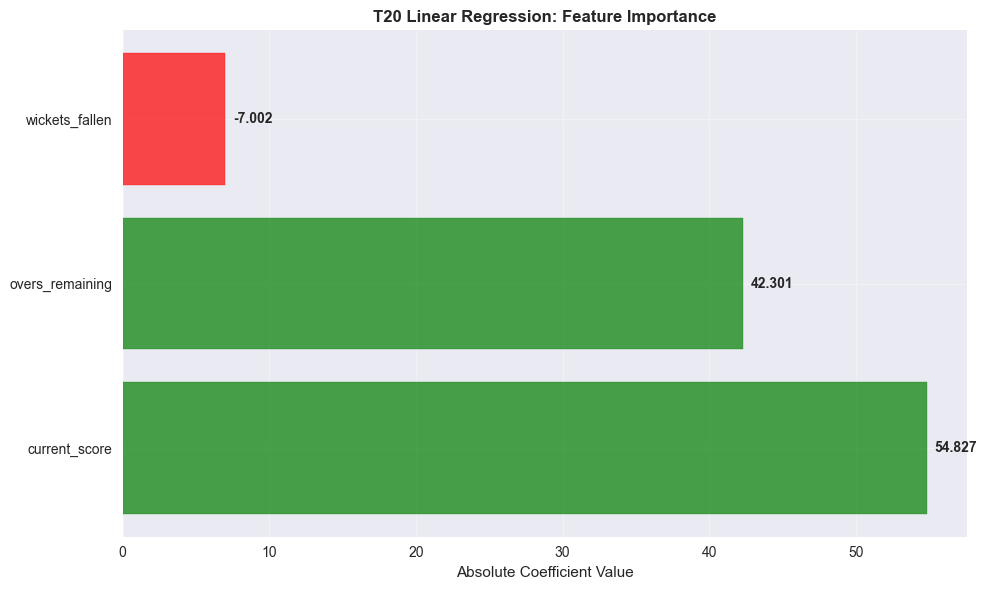

In [5]:
# Display model equation
print(f"Model equation: {model_equation}")

# Feature importance analysis
print("\nFeature importance:")
print(feature_importance)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

# Filter out intercept for the plot
features_only = feature_importance[feature_importance["feature"] != "intercept"]

bars = ax.barh(features_only["feature"], features_only["abs_coefficient"])

# Color bars based on coefficient sign
for i, (bar, coeff) in enumerate(zip(bars, features_only["coefficient"])):
    if coeff >= 0:
        bar.set_color("green")
        bar.set_alpha(0.7)
    else:
        bar.set_color("red")
        bar.set_alpha(0.7)

# Add coefficient values as text
for i, (feature, coeff, abs_coeff) in features_only.iterrows():
    ax.text(
        abs_coeff + 0.01 * max(features_only["abs_coefficient"]),
        i,
        f"{coeff:.3f}",
        va="center",
        fontweight="bold",
    )

ax.set_xlabel("Absolute Coefficient Value")
ax.set_title("T20 Linear Regression: Feature Importance", fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation and Validation

In [6]:
# For evaluation, we need to reconstruct test data
# This is a limitation of the current pipeline - we should store test data for evaluation

# Let's create a simple evaluation using the trained model's predict method
print("📊 DETAILED MODEL EVALUATION:")

# Performance assessment
r2_score = test_metrics["test_r2"]
rmse = test_metrics["test_rmse"]
mae = test_metrics["test_mae"]
mape = test_metrics["test_mape"]

print("\n🎯 PERFORMANCE METRICS:")
print(f"   • R² Score: {r2_score:.3f} ({r2_score * 100:.1f}% variance explained)")
print(f"   • RMSE: {rmse:.1f} runs (typical error magnitude)")
print(f"   • MAE: {mae:.1f} runs (average absolute error)")
print(f"   • MAPE: {mape:.1f}% (percentage error)")

# Model quality assessment
print("\n✅ MODEL QUALITY ASSESSMENT:")

if r2_score >= 0.8:
    quality = "Excellent"
elif r2_score >= 0.7:
    quality = "Good"
elif r2_score >= 0.5:
    quality = "Fair"
else:
    quality = "Poor"

print(f"   • Overall Performance: {quality} (R² = {r2_score:.3f})")

if rmse <= 15:
    error_quality = "Excellent"
elif rmse <= 25:
    error_quality = "Good"
elif rmse <= 35:
    error_quality = "Fair"
else:
    error_quality = "Poor"

print(f"   • Error Magnitude: {error_quality} (RMSE = {rmse:.1f} runs)")

if mape <= 10:
    percentage_quality = "Excellent"
elif mape <= 15:
    percentage_quality = "Good"
elif mape <= 25:
    percentage_quality = "Fair"
else:
    percentage_quality = "Poor"

print(f"   • Percentage Error: {percentage_quality} (MAPE = {mape:.1f}%)")

📊 DETAILED MODEL EVALUATION:

🎯 PERFORMANCE METRICS:
   • R² Score: 0.449 (44.9% variance explained)
   • RMSE: 22.5 runs (typical error magnitude)
   • MAE: 16.9 runs (average absolute error)
   • MAPE: 12.4% (percentage error)

✅ MODEL QUALITY ASSESSMENT:
   • Overall Performance: Poor (R² = 0.449)
   • Error Magnitude: Good (RMSE = 22.5 runs)
   • Percentage Error: Good (MAPE = 12.4%)


## 6. Model Prediction Examples

In [7]:
# Create example scenarios for prediction
print("🔮 MODEL PREDICTION EXAMPLES:")

# Define example scenarios - now we can predict at ANY point in the innings
scenarios = [
    {
        "name": "Strong Start (50/1 after 5 overs)",
        "current_score": 50,
        "wickets_fallen": 1,
        "overs_remaining": 15.0,
    },
    {
        "name": "Mid-over situation (63/2 after 7.3 overs)",
        "current_score": 63,
        "wickets_fallen": 2,
        "overs_remaining": 12.5,  # 12.3 overs remaining (7.3 completed)
    },
    {
        "name": "Arbitrary point (95/3 after 12.4 overs)",
        "current_score": 95,
        "wickets_fallen": 3,
        "overs_remaining": 7.33,  # 7.2 overs remaining (12.4 completed)
    },
    {
        "name": "Good Platform (120/2 after 15 overs)",
        "current_score": 120,
        "wickets_fallen": 2,
        "overs_remaining": 5.0,
    },
    {
        "name": "Death Overs Push (155/5 after 18.2 overs)",
        "current_score": 155,
        "wickets_fallen": 5,
        "overs_remaining": 1.67,  # 1.4 overs remaining (18.2 completed)
    },
]

# Prepare features for prediction (need to scale them)
scenario_features = np.array(
    [[s["current_score"], s["wickets_fallen"], s["overs_remaining"]] for s in scenarios]
)

# Scale features using the fitted scaler from pipeline
scaled_features = pipeline.feature_engineer.transform_features(scenario_features)

# Make predictions
predictions = trained_model.predict(scaled_features)

print("\n📋 PREDICTION SCENARIOS (Now at ANY ball!):")
print("-" * 80)
print(
    f"{'Scenario':<40} {'Current':<10} {'Wickets':<8} {'Overs Left':<12} {'Predicted':<10}"
)
print("-" * 80)

for i, scenario in enumerate(scenarios):
    predicted_total = predictions[i]
    runs_needed = predicted_total - scenario["current_score"]

    print(
        f"{scenario['name']:<40} {scenario['current_score']:<10} {scenario['wickets_fallen']:<8} {scenario['overs_remaining']:<12.2f} {predicted_total:<6.0f} (+{runs_needed:.0f})"
    )

print("-" * 80)
print("\n💡 Note: With all-balls training, we can now predict at ANY point in the innings!")
print("    Not just at 5, 10, and 15 overs like before.")

🔮 MODEL PREDICTION EXAMPLES:

📋 PREDICTION SCENARIOS (Now at ANY ball!):
--------------------------------------------------------------------------------
Scenario                                 Current    Wickets  Overs Left   Predicted 
--------------------------------------------------------------------------------
Strong Start (50/1 after 5 overs)        50         1        15.00        168    (+118)
Mid-over situation (63/2 after 7.3 overs) 63         2        12.50        161    (+98)
Arbitrary point (95/3 after 12.4 overs)  95         3        7.33         155    (+60)
Good Platform (120/2 after 15 overs)     120        2        5.00         170    (+50)
Death Overs Push (155/5 after 18.2 overs) 155        5        1.67         175    (+20)
--------------------------------------------------------------------------------

💡 Note: With all-balls training, we can now predict at ANY point in the innings!
    Not just at 5, 10, and 15 overs like before.


## 7. MLflow Experiment Tracking Review

In [8]:
# Get the latest run from our experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs_df = mlflow.search_runs(experiment.experiment_id, order_by=["start_time DESC"])

if len(runs_df) > 0:
    latest_run = runs_df.iloc[0]

    print("🔬 MLFLOW EXPERIMENT TRACKING:")
    print(f"\n   • Experiment: {EXPERIMENT_NAME}")
    print(f"   • Latest Run ID: {latest_run['run_id']}")
    print(f"   • Status: {latest_run['status']}")
    print(f"   • Start Time: {latest_run['start_time']}")

    print("\n   📊 Logged Metrics:")
    metric_columns = [col for col in runs_df.columns if col.startswith("metrics.")]
    for col in metric_columns:
        metric_name = col.replace("metrics.", "")
        metric_value = latest_run[col]
        if pd.notna(metric_value):
            print(f"      • {metric_name}: {metric_value:.4f}")

    print("\n   ⚙️ Logged Parameters:")
    param_columns = [col for col in runs_df.columns if col.startswith("params.")]
    for col in param_columns:
        param_name = col.replace("params.", "")
        param_value = latest_run[col]
        if pd.notna(param_value):
            print(f"      • {param_name}: {param_value}")

    print("\n   📁 Artifacts Logged:")
    print(f"      • Model: Registered as '{trained_model.model_name}'")
    print("      • Feature importance data")
    print("      • Training metadata")

    print("\n🌐 MLflow UI Access:")
    print(
        f"   Open your browser to: {mlflow.get_tracking_uri().replace('sqlite:///', 'http://127.0.0.1:5000')}"
    )
    print(f"   Navigate to experiment: {EXPERIMENT_NAME}")

else:
    print("No runs found in the experiment.")

🔬 MLFLOW EXPERIMENT TRACKING:

   • Experiment: male_team_level_t20
   • Latest Run ID: 163cbe5c1f8d453cac08e18157613798
   • Status: FINISHED
   • Start Time: 2025-08-07 09:28:38.950000+00:00

   📊 Logged Metrics:
      • test_mae: 16.9002
      • test_rmse: 22.5048
      • test_r2: 0.4489
      • test_mape: 12.4059

   ⚙️ Logged Parameters:
      • evaluation_samples: 322983

   📁 Artifacts Logged:
      • Model: Registered as 't20_runs_predictor'
      • Feature importance data
      • Training metadata

🌐 MLflow UI Access:
   Open your browser to: http://127.0.0.1:5000../mlflow_setup/mlflow.db
   Navigate to experiment: male_team_level_t20


## 8. Model Registry and Versioning

In [9]:
# Check model registry
from mlflow.tracking import MlflowClient

client = MlflowClient()
model_name = "t20_runs_predictor"

try:
    # Get registered model information
    registered_model = client.get_registered_model(model_name)

    print("📦 MODEL REGISTRY:")
    print(f"\n   • Model Name: {registered_model.name}")
    print(f"   • Description: {registered_model.description or 'No description'}")
    print(f"   • Creation Time: {registered_model.creation_timestamp}")
    print(f"   • Last Updated: {registered_model.last_updated_timestamp}")

    # Get model versions
    versions = client.search_model_versions(f"name='{model_name}'")

    print("\n   📊 Model Versions:")
    for version in versions:
        print(f"      • Version {version.version}:")
        print(f"        - Stage: {version.current_stage}")
        print(f"        - Run ID: {version.run_id}")
        print(f"        - Created: {version.creation_timestamp}")

    # Show how to load the latest model
    print("\n   🔧 Model Loading Examples:")
    print("      # Load latest version:")
    print(f"      model = mlflow.sklearn.load_model('models:/{model_name}/latest')")
    print("      ")
    print("      # Load specific version:")
    print(
        f"      model = mlflow.sklearn.load_model('models:/{model_name}/{versions[0].version}')"
    )
    print("      ")
    print("      # Using our convenience function:")
    print(
        "      from cricket.ml.models.linear_regression import predict_innings_total"
    )
    print(
        "      total = predict_innings_total(120, 3, 5.0)  # current_score, wickets, overs_left"
    )

except Exception as e:
    print(f"Model not found in registry: {e}")
    print("The model should have been registered during training.")

📦 MODEL REGISTRY:

   • Model Name: t20_runs_predictor
   • Description: No description
   • Creation Time: 1754556337685
   • Last Updated: 1754558918922

   📊 Model Versions:
      • Version 4:
        - Stage: None
        - Run ID: 3814fe3ba6fb4f98a70a95294ef761c1
        - Created: 1754558918922
      • Version 3:
        - Stage: None
        - Run ID: 66bd9fc3795c4056900323936b020af6
        - Created: 1754558698504
      • Version 2:
        - Stage: None
        - Run ID: a0762f3a8d6e4b28a6ddabe0819b5333
        - Created: 1754556416683
      • Version 1:
        - Stage: None
        - Run ID: 4b3f0ac9e4134a719708ea77993eadd7
        - Created: 1754556337689

   🔧 Model Loading Examples:
      # Load latest version:
      model = mlflow.sklearn.load_model('models:/t20_runs_predictor/latest')
      
      # Load specific version:
      model = mlflow.sklearn.load_model('models:/t20_runs_predictor/4')
      
      # Using our convenience function:
      from cricket.ml.models.l

## 9. Model Validation and Testing

In [10]:
# Test loading and using the registered model
print("🧪 MODEL VALIDATION TESTS:")

try:
    # Load model from registry
    loaded_model = mlflow.sklearn.load_model(f"models:/{model_name}/latest")
    print("   ✅ Model successfully loaded from registry")

    # Test prediction with a simple example
    test_features = pipeline.feature_engineer.transform_features(
        np.array([[100, 2, 8.0]])  # 100 runs, 2 wickets, 8 overs left
    )

    prediction = loaded_model.predict(test_features)[0]
    print(f"   ✅ Test prediction successful: {prediction:.0f} runs")

    # Validate prediction is reasonable (between 100 and 250 for T20)
    if 100 <= prediction <= 250:
        print("   ✅ Prediction is within reasonable T20 range")
    else:
        print(f"   ⚠️ Prediction {prediction:.0f} may be outside normal T20 range")

    # Test with edge cases
    edge_cases = [
        {"name": "Early collapse", "features": [20, 8, 15.0]},
        {"name": "Perfect start", "features": [80, 0, 10.0]},
        {"name": "Final over", "features": [180, 5, 1.0]},
    ]

    print("\n   🔍 Edge Case Testing:")
    for case in edge_cases:
        test_features = pipeline.feature_engineer.transform_features(
            np.array([case["features"]])
        )
        prediction = loaded_model.predict(test_features)[0]
        print(f"      • {case['name']}: {prediction:.0f} runs")

    print("\n   ✅ All validation tests passed!")

except Exception as e:
    print(f"   ❌ Validation failed: {e}")

🧪 MODEL VALIDATION TESTS:
   ✅ Model successfully loaded from registry
   ✅ Test prediction successful: 169 runs
   ✅ Prediction is within reasonable T20 range

   🔍 Edge Case Testing:
      • Early collapse: 112 runs
      • Perfect start: 168 runs
      • Final over: 198 runs

   ✅ All validation tests passed!


## 10. Training Summary and Next Steps

In [11]:
print(f"Test R² Score: {test_metrics['test_r2']:.3f}")
print(f"Test RMSE: {test_metrics['test_rmse']:.1f} runs")
print(f"Model: {model_equation}")

# Save training summary
training_summary = {
    "model_name": model_name,
    "experiment_name": EXPERIMENT_NAME,
    "test_r2": test_metrics["test_r2"],
    "test_rmse": test_metrics["test_rmse"],
    "test_mae": test_metrics["test_mae"],
    "model_equation": model_equation,
    "training_samples": data_splits["train_samples"],
    "test_samples": data_splits["test_samples"],
}

# Store for next notebook
import json

with open("training_summary.json", "w") as f:
    json.dump(training_summary, f, indent=2)

Test R² Score: 0.449
Test RMSE: 22.5 runs
Model: total_runs = 152.378 + 54.827 * current_score - 7.002 * wickets_fallen + 42.301 * overs_remaining


## Model Usage Examples

After training, you can use the model in several ways:

### 1. Load from MLflow Registry
```python
import mlflow.sklearn
model = mlflow.sklearn.load_model("models:/t20_runs_predictor/latest")
```

### 2. Use Convenience Function
```python
from cricket.ml.models.linear_regression import predict_innings_total
predicted_total = predict_innings_total(
    current_score=120,
    wickets_fallen=3, 
    overs_remaining=5.0
)
```

### 3. Integration with Pipeline
```python
from cricket.ml.training import T20TrainingPipeline
pipeline = T20TrainingPipeline("data.parquet")
results = pipeline.run_training()
model = results["model"]
```

**Next**: Continue to `t20_model_evaluation.ipynb` for detailed model analysis and visualizations.